### Inicialização

In [ ]:
!pip install "requests[security]"

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import rospy
import tf
from utils import *
import numpy as np
import requests
import base64
import ast

rospy.init_node("recognition")
rgbd = RGBD()

locations = {
    'start' : [0,0,0],
    'mesinha': [0.05, 1.11, 90],
    'mesonaA': [1.57, 0.2, -90],
    'mesonaB': [1.2, 0.98, 90],
    'prateleira': [2.25, 4.0, 90],
    'prateleira_pickup': [2.25, 4.15, 90],
    'delivery_area': [0.643, 3.527, 180],
    'pessoa_esquerda': [0.547, 2.892, 180],
    'pessoa_direita': [0.547, 3.851, 180]
}

def move_to_location(loc):
    move_arm_init()
    move_head_tilt(0)
    x, y, yaw = locations[loc]
    move_base_goal(x, y, yaw)

def request_classification(img):
    url = 'http://172.19.0.1:5000/detect_objs'
    myobj = {
        "img":str(base64.b64encode(img.ravel(), 'utf-8')),
        "h": img.shape[0],
        "w": img.shape[1],    
        "c": img.shape[2]
    }
    return ast.literal_eval(requests.post(url, json= myobj).text)

def imgcoords2world(x, y, rgbd_obj):
    img = rgbd_obj.get_image()
    points_data = rgbd_obj._points_data
    xw = points_data['x'][y, x]
    yw = points_data['y'][y, x]
    zw = points_data['z'][y, x]
    return (xw, yw, zw)

def get_centroid(top_left, bottom_right):
    c_x = top_left[0] + (bottom_right[0] - top_left[0])/2
    c_y = top_left[1] + (bottom_right[1] - top_left[1])/2
    return (int(c_x), int(c_y))

class ObjectTracker():
    def __init__(self):
        self._br = tf.TransformBroadcaster()
        # ポイントクラウドのサブスクライバのコールバックに_cloud_cbメソッドを登録
        self._cloud_sub = rospy.Subscriber(
            "/hsrb/head_rgbd_sensor/depth_registered/rectified_points",
            PointCloud2, self._cloud_cb)
        self._frame_name = "objeto"
        self.x = 0
        self.y = 0
        self.z = 0
        
    def set_obj_coords(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

    def _cloud_cb(self, msg):
        self._points_data = ros_numpy.numpify(msg)            

        self._br.sendTransform(
            (x, y, z), tf.transformations.quaternion_from_euler(0, 0, 0),
            rospy.Time(msg.header.stamp.secs, msg.header.stamp.nsecs),
            self._frame_name,
            msg.header.frame_id)

### Comunicação com servidor

In [1]:
!ping host.docker.internal

PING host.docker.internal (172.17.0.1) 56(84) bytes of data.
64 bytes from host.docker.internal (172.17.0.1): icmp_seq=1 ttl=64 time=0.036 ms
64 bytes from host.docker.internal (172.17.0.1): icmp_seq=2 ttl=64 time=0.045 ms
64 bytes from host.docker.internal (172.17.0.1): icmp_seq=3 ttl=64 time=0.033 ms
64 bytes from host.docker.internal (172.17.0.1): icmp_seq=4 ttl=64 time=0.031 ms
64 bytes from host.docker.internal (172.17.0.1): icmp_seq=5 ttl=64 time=0.034 ms
64 bytes from host.docker.internal (172.17.0.1): icmp_seq=6 ttl=64 time=0.067 ms
64 bytes from host.docker.internal (172.17.0.1): icmp_seq=7 ttl=64 time=0.042 ms
64 bytes from host.docker.internal (172.17.0.1): icmp_seq=8 ttl=64 time=0.035 ms
64 bytes from host.docker.internal (172.17.0.1): icmp_seq=9 ttl=64 time=0.032 ms
^C

--- host.docker.internal ping statistics ---
9 packets transmitted, 9 received, 0% packet loss, time 8096ms
rtt min/avg/max/mdev = 0.031/0.039/0.067/0.012 ms


In [1]:
!ping 172.19.0.1

PING 172.19.0.1 (172.19.0.1) 56(84) bytes of data.
64 bytes from 172.19.0.1: icmp_seq=1 ttl=64 time=0.038 ms
64 bytes from 172.19.0.1: icmp_seq=2 ttl=64 time=0.029 ms
64 bytes from 172.19.0.1: icmp_seq=3 ttl=64 time=0.033 ms
64 bytes from 172.19.0.1: icmp_seq=4 ttl=64 time=0.029 ms
64 bytes from 172.19.0.1: icmp_seq=5 ttl=64 time=0.043 ms
^C

--- 172.19.0.1 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4062ms
rtt min/avg/max/mdev = 0.029/0.034/0.043/0.007 ms


In [2]:
!route

Kernel IP routing table
Destination     Gateway         Genmask         Flags Metric Ref    Use Iface
default         172.19.0.1      0.0.0.0         UG    0      0        0 eth0
172.19.0.0      0.0.0.0         255.255.0.0     U     0      0        0 eth0


In [1]:
# !pip install requests
!pip install "requests[security]"

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 62 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 149 kB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 138 kB 2.7 MB/s eta 0:00:01


In [10]:
import requests

# url = 'http://127.0.0.1:5000/countries'
# url = 'http://0.0.0.0:5000/countries'
# url = 'http://172.17.0.1:5000/countries'
url = 'http://172.19.0.1:5000/countries'
myobj = {"name":"Germany", "capital": "Berlin", "area": 357022}

x = requests.post(url, json= myobj)

print(x.text)


<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN"
  "http://www.w3.org/TR/html4/loose.dtd">
<html>
  <head>
    <title>KeyError: &#x27;img&#x27; // Werkzeug Debugger</title>
    <link rel="stylesheet" href="?__debugger__=yes&amp;cmd=resource&amp;f=style.css"
        type="text/css">
    <!-- We need to make sure this has a favicon so that the debugger does
         not accidentally trigger a request to /favicon.ico which might
         change the application's state. -->
    <link rel="shortcut icon"
        href="?__debugger__=yes&amp;cmd=resource&amp;f=console.png">
    <script src="?__debugger__=yes&amp;cmd=resource&amp;f=debugger.js"></script>
    <script type="text/javascript">
      var TRACEBACK = 140153817764816,
          CONSOLE_MODE = false,
          EVALEX = true,
          EVALEX_TRUSTED = false,
          SECRET = "U6LLe12GxxoQV7a38GN6";
    </script>
  </head>
  <body style="background-color: #fff">
    <div class="debugger">
<h1>KeyError</h1>
<div class="d

In [7]:
image_data.shape

(480, 640, 3)

In [21]:
image_data.ravel().shape

(921600,)

In [40]:
url = 'http://172.19.0.1:5000/detect_objs'
myobj = {
    "img":str(base64.b64encode(image_data.ravel(), 'utf-8')),
    "h": image_data.shape[0],
    "w": image_data.shape[1],    
    "c": image_data.shape[2]
}

results = requests.post(url, json= myobj)

# print(x.text)

In [44]:
import base64
import ast
import tf

def request_classification(img):
    url = 'http://172.19.0.1:5000/detect_objs'
    myobj = {
        "img":str(base64.b64encode(img.ravel(), 'utf-8')),
        "h": img.shape[0],
        "w": img.shape[1],    
        "c": img.shape[2]
    }
    return ast.literal_eval(requests.post(url, json= myobj).text)

def imgcoords2world(x, y, rgbd_obj):
    img = rgbd_obj.get_image()
    points_data = rgbd_obj._points_data
    xw = points_data['x'][y, x]
    yw = points_data['y'][y, x]
    zw = points_data['z'][y, x]
    return (xw, yw, zw)

def get_centroid(top_left, bottom_right):
    c_x = top_left[0] + (bottom_right[0] - top_left[0])/2
    c_y = top_left[1] + (bottom_right[1] - top_left[1])/2
    return (int(c_x), int(c_y))

result = request_classification(rgbd.get_image())
obj = result["apple"][0]
obj_img_center = get_centroid((obj[0], obj[1]), (obj[2], obj[3]))
x, y, z = imgcoords2world(obj_img_center[0], obj_img_center[1], rgbd)
print(x, y, z)
# br = tf.TransformBroadcaster()

# for prediction, obj_name in zip(result["predictions"], result["object_names"]):
#     print(obj_name)

(-0.13041593, 0.24348038, 0.62060374)


In [41]:
br = tf.TransformBroadcaster()
br.sendTransform(
            (x, y, z), tf.transformations.quaternion_from_euler(0, 0, 0),
            rospy.Time.now(),
            "objeto",
            "head_rgbd_sensor_rgb_frame")

In [47]:
objt = ObjectTracker()
objt.set_obj_coords(x, y, z)

In [46]:
class ObjectTracker():
    def __init__(self):
        self._br = tf.TransformBroadcaster()
        # ポイントクラウドのサブスクライバのコールバックに_cloud_cbメソッドを登録
        self._cloud_sub = rospy.Subscriber(
            "/hsrb/head_rgbd_sensor/depth_registered/rectified_points",
            PointCloud2, self._cloud_cb)
        self._frame_name = "objeto"
        self.x = 0
        self.y = 0
        self.z = 0
        
    def set_obj_coords(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

    def _cloud_cb(self, msg):
        self._points_data = ros_numpy.numpify(msg)            

        self._br.sendTransform(
            (x, y, z), tf.transformations.quaternion_from_euler(0, 0, 0),
            rospy.Time(msg.header.stamp.secs, msg.header.stamp.nsecs),
            self._frame_name,
            msg.header.frame_id)

### Setando HUE dos objetos

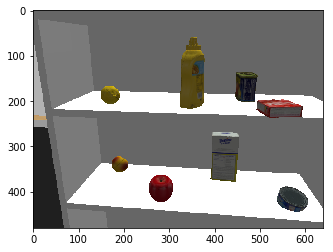

In [6]:
# Get image data
image_data = rgbd.get_image()
# Display the image data
plt.imshow(image_data)


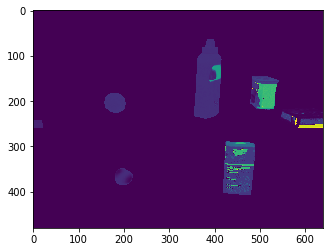

In [7]:
h_image = rgbd.get_h_image()
# Display the hue channel
plt.imshow(h_image)

In [8]:
from ipywidgets import interact

def f(lower = 0, upper = 255):
    yellow_region = (h_image > lower) & (h_image < upper)
    plt.imshow(yellow_region)


interact(f, lower=(0, 255, 5), upper=(0, 255, 5))

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0wLCBkZXNjcmlwdGlvbj11J2xvd2VyJywgbWF4PTI1NSwgc3RlcD01KSwgSW50U2xpZGVyKHZhbHVlPTI1NSwgZGVzY3JpcHTigKY=


<function __main__.f>

### Navegação

In [66]:
move_to_location('prateleira')

### Pegando posição do objeto

In [44]:
move_head_tilt(-0.3)

True

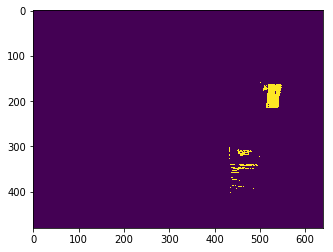

In [9]:
# image_data = rgbd.get_image()
rgbd.set_h(245, 255)
region = rgbd.get_region()
plt.imshow(region)

In [10]:
rgbd.get_xyz()

[0.2797775, 0.0152991535, 0.5586361]

In [68]:
rgbd.set_coordinate_name("objeto")

In [28]:
trans = get_relative_coordinate("odom", "objeto")
x = trans.translation.x
y = trans.translation.y
z = trans.translation.z
x, y, z

(2.4832446488334368, 4.61049961557407, 0.7999918846499854)

In [71]:
# ハンドを開く Open the hand
move_hand(1)
# Move the end effector by using inverse kinematics
move_wholebody_ik(x, y, z, 0, 90, 180)
# Close the hand
move_hand(0)
# Move the hand to the initial position
move_arm_init()

True

In [74]:
move_to_location('start')
move_to_location('delivery_area')

### Testes

In [38]:
move_head_tilt(0)
move_arm_init()
move_to_location('start')

In [29]:
# whole_body.get_current_rpy()
# arm.get_current_pose()
pose = whole_body.get_current_pose()
pos = pose.pose.position
pose

header: 
  seq: 0
  stamp: 
    secs: 1127
    nsecs: 538000000
  frame_id: "odom"
pose: 
  position: 
    x: 2.45518370622
    y: 4.09415353343
    z: 0.672716126847
  orientation: 
    x: -0.706684474259
    y: -0.0406328588062
    z: -0.705215484296
    w: 0.0402137456099

In [37]:
move_wholebody_ik(pos.x, pos.y, pos.z, -90, 0, -90)

True

In [7]:
joint_values = whole_body.get_current_joint_values()
joint_values

[3.1320139734731267,
 0.7705636979890608,
 -2.3736689781201377,
 3.607505545432198e-05,
 0.00013831850127754564,
 0.0004217055111053192,
 -0.00018528658030536604,
 -0.00019178729022062413,
 0.0]

In [22]:
move_arm_init()

True

In [6]:
whole_body.get_joints()

['odom_y',
 'odom_x',
 'odom_r',
 'arm_lift_joint',
 'arm_flex_joint',
 'arm_roll_joint',
 'wrist_flex_joint',
 'wrist_roll_joint',
 'wrist_ft_sensor_frame_joint',
 'wrist_ft_sensor_frame_inverse_joint',
 'hand_palm_joint']

In [43]:
move_arm_init()
move_to_location('prateleira')
for jointv in [0.05, 0.1, 0.15]:    
    joint_values = whole_body.get_current_joint_values()
    print(joint_values)
    joint_values[3] = jointv
    whole_body.set_joint_value_target(joint_values)
    whole_body.go(wait = True)
    result = request_classification(rgbd.get_image())
move_arm_init()

[3.7219761220726477, 2.0456524997601186, 1.4794386832607234, -3.464515404142817e-05, -0.00022491005980818102, -1.5698164986313023, -1.5727427343192266, 0.0005210872367431563, 0.0]
[3.722831976001183, 2.047137841494697, 1.4640208433009045, 0.0481771593350463, -0.00016456677350262794, -1.5688090036251725, -1.5759860346438987, -0.0005850498517405711, 0.0]
[3.7235772694858498, 2.046347426175722, 1.478433102530344, 0.10037399205434902, -0.00029396880446164175, -1.5683552751755268, -1.5789836969300186, -0.0006038587843990584, 0.0]


True

In [2]:
move_to_location('prateleira')

In [6]:
wp_estante_cima = [2.05, 4.3, 0.92]
wp_estante_baixo = [2.05, 4.3, 0.75]
# wp_estante_baixo = [1.95, 4.1, 0.75]
wp_A = wp_estante_cima
move_wholebody_ik(wp_A[0], wp_A[1], wp_A[2], -90, 0, -90)

True

### Execução prova

In [ ]:
wp_estante_cima = [1.90, 4.3, 0.92]
wp_estante_baixo = [1.90, 4.3, 0.62]
objetos = [
    "mustard_bottle",
    "apple"        
]
pessoas = [
    "pessoa_esquerda",
    "pessoa_direita"
]
whole_body.set_workspace([-1.0, 1.0, -0.3, 0.3])
# tilt_angles = [-0.35, -0.4, -0.45]
tilt_angles = [-0.4]
for objeto, pessoa in zip(objetos, pessoas):
    print("Pegando objeto: %s" % (objeto))
    move_to_location('prateleira')
    xs, ys, zs = [], [], []
    for angle in tilt_angles:
        move_head_tilt(angle)
        result = request_classification(rgbd.get_image())
        if objeto in result:
            obj = result[objeto][0]
            obj_img_center = get_centroid((obj[0], obj[1]), (obj[2], obj[3]))
            x, y, z = imgcoords2world(obj_img_center[0], obj_img_center[1], rgbd)
            xs.append(x)
            ys.append(y)
            zs.append(z)
    if len(xs) == 0:
        continue
    x = np.mean(xs)
    y = np.mean(ys)
    z = np.mean(zs)
    
    objt = ObjectTracker()
    objt.set_obj_coords(x, y, z)

    trans = get_relative_coordinate("odom", "objeto")
#     trans = get_relative_coordinate("map", "objeto")
    x = trans.translation.x
    y = trans.translation.y
    z = trans.translation.z

    target = np.array([x, y, z])
    if z > 0.7:
        print("Usando waypoint cima!")
        starting_wp = wp_estante_cima
    else:
        print("Usando waypoint baixo!")
        starting_wp = wp_estante_baixo
    wp1 = target + np.array([0, -0.1, 0.15])
    wp2 = target + np.array([0, 0, 0.15])
    wp3 = target + np.array([0, -0.1, 0.15])

    move_wholebody_ik(starting_wp[0], starting_wp[1], starting_wp[2], -90, 0, -90)
    move_hand(1)
    move_wholebody_ik(wp1[0], wp1[1], wp1[2], -90, 0, -90)
    move_wholebody_ik(x, y, z, -90, 0, -90)
    move_hand(0)
    move_wholebody_ik(wp2[0], wp2[1], wp2[2], -90, 0, -90)
    move_wholebody_ik(wp3[0], wp3[1], wp3[2], -90, 0, -90)
    move_wholebody_ik(starting_wp[0], starting_wp[1], starting_wp[2], -90, 0, -90)
    
    move_arm_init()
    move_to_location(pessoa)
    move_arm_neutral()
    move_hand(1)
    move_hand(0)
    move_arm_init()

Pegando objeto: mustard_bottle
Usando waypoint cima!
Pegando objeto: apple
Usando waypoint baixo!
